# Embeddings con OpenAI
Embeddings es un proceso mediante el cual se utiliza alguna tecnica/algoritmo que sea capaz de convertir palabras o texto a vectores de N dimensiones. Estos vectores contienen cierto nivel de información semantica sobre el texto o palabra. Por ejemplo, palabras que son muy similares van a tener valores cercanos en sus representaciones en vectores.

Hay varios modelos que son capaces de hacer un embedding de nuestro texto, en este cuaderno estaremos utilizando el embedding de OpenAI, el cual tiene la capacidad de posicionas muy bien palabras o textos segun su semantica. Este es el mismo embedding que utiliza GPT3. En este cuaderno estarás haciendo embedding de un texto para despues poder buscar cosas dentro de este texto por medio de preguntas en lenguaje natural.

In [1]:
# Importamos todas las dependencias requeridas, en este caso será Gradio para desarrollar la interfaz grafica y openai para realizar los llamados a su API 
import gradio as gr
import openai
import pandas as pd

from openai.embeddings_utils import get_embedding
from openai.embeddings_utils import cosine_similarity

c:\Users\luisg\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Definimos la API Key para vincular el cuaderno con nuestra cuenta de OpenAI
openai.api_key = ""

# Que es y cómo usar embeddings
Al hacer embedding de un dato, lo estamos convirtiendo a un vector numérico, datos similares estarán más cercanos entre si cuando semanticamente son similares

In [3]:
# Se puede hacer embeeding de palabras o cadenas de texto
palabras = ["casa", "perro", "gato", "lobo", "leon", "zebra", "tigre"]

In [4]:
diccionario = {}
for i in palabras:
    diccionario[i] = get_embedding(i, engine="text-embedding-ada-002")
    

In [6]:
diccionario.keys()

dict_keys(['casa', 'perro', 'gato', 'lobo', 'leon', 'zebra', 'tigre'])

In [9]:
palabra = "gato"
print("Primeros 10 valores de {}:\n".format(palabra), diccionario[palabra][:10])
print("\n")
print("Número de dimensiones del dato embebido\n", len(diccionario[palabra]))


Primeros 10 valores de gato:
 [-0.024576973170042038, 0.009653845801949501, -0.0003061550669372082, -0.011156566441059113, -0.007181836757808924, 0.01183311641216278, -0.022013889625668526, -0.024954279884696007, -0.0052172401919960976, -0.019047480076551437]


Número de dimensiones del dato embebido
 1536


## Comparar dos embeddings
Debido a que los embeddings son una representacion vectorial de los datos en un espacio latente, podemos medir la distancia entre dos vectores y asi obtener que tan similares son. Podemos comparar una palabra nueva o alguna de las que ya fueron embebidas 
OJO: No necesariamente es similitud al objeto. Ej. perro y gato aun siendo "opuestos" semanticamente estan cerca pues tienen una relación.

In [13]:
n_palabra = "agujero negro" # Palabra nueva a comparar
palabra_comparar = "perro" # Palabra del diccionario con la que compararemos la nueva palabra
n_palabra_embed = get_embedding(n_palabra, engine="text-embedding-ada-002")
similitud = cosine_similarity(diccionario[palabra_comparar], n_palabra_embed)
print(similitud)

0.8159836735319491


# Sumar embeddings
Como los vectores contienen valores numericos, podemos sumarlos y el resultado será un nuevo vector de un concepto que una los elementos sumados

In [14]:
# Suma dos listas usando pandas
sumados = (pd.DataFrame(diccionario["leon"])) + (pd.DataFrame(diccionario["zebra"]))
len(sumados)

for key, value in diccionario.items():
    print(key, ":", cosine_similarity(diccionario[key], sumados))


casa : [0.82819415]
perro : [0.85046401]
gato : [0.85630059]
lobo : [0.85639036]
leon : [0.9531031]
zebra : [0.95310309]
tigre : [0.88060081]


# Aplicacion de un Chatbot

Usaremos Gradio para hacer una interfaz básica donde podremos hacer preguntas y obtendremos una respuesta. 
Para esto reutilizaremos lo que hemos visto hasta el momento pero usaremos el archivo de **chatbot_qa.csv**

In [16]:
def embed_text(path="texto.csv"):
    conocimiento_df = pd.read_csv(path)
    conocimiento_df['Embedding'] = conocimiento_df['texto'].apply(lambda x: get_embedding(x, engine='text-embedding-ada-002'))
    conocimiento_df.to_csv('embeddings.csv')
    return conocimiento_df

def buscar(busqueda, datos, n_resultados=5):
    busqueda_embed = get_embedding(busqueda, engine="text-embedding-ada-002")
    datos["Similitud"] = datos['Embedding'].apply(lambda x: cosine_similarity(x, busqueda_embed))
    datos = datos.sort_values("Similitud", ascending=False)
    return datos.iloc[:n_resultados][["texto", "Similitud", "Embedding"]]

texto_emb = embed_text("./chatbot_qa.csv")

with gr.Blocks() as demo:
    busqueda = gr.Textbox(label="Buscar")
    output = gr.DataFrame(headers=['texto'])
    greet_btn = gr.Button("Preguntar")
    greet_btn.click(fn=buscar, inputs=[busqueda, gr.DataFrame(texto_emb)], outputs=output)

demo.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


# Procesar datos de un PDF
Haremos ahora un ejemplo donde leemos un PDF para poder hacer preguntas y traer un exctracto del PDF

In [21]:
# pip install langchain pypdf
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter

loader = PyPDFLoader("Todos.pdf")
pages = loader.load_and_split()

In [22]:
# Un elemento por cada página
pages[157].page_content

'f) Varíe la frecuencia en el generador, hasta escuchar un sonido y siga incrementándola hasta \nque se deje de oír.  \n \n3.-De acuerdo a lo es cuchado, ¿cuál es el rango de la frecuencia audible?  \n \ng) Mantenga una frecuencia audible y a continuación agregue un capacitor que sirva como \nfiltro, según se muestra en la figura 2.8 y escuche el cambio de sonido.  \n \n \n \n4.- ¿Cómo funciona un capacitor como filtro para señales de audio y qué concluye respecto a \nlo sucedido?  \n \nAlmacenamiento de energía en un capacitor  \nh) Verifique que el capacitor de 2200 mF se encuentre descargado y posteriormente \nconéctelo a la fuente de poder, como se indica en la figura 2.9 . \n \ni) Desconecte el capacitor, teniendo cuidado de no tocar sus terminales y conéctelo a \nlas terminales del voltímetro según se muestra en la figura. 2.10.'

In [23]:
# Objeto que va a hacer los cortes en el texto
split = CharacterTextSplitter(chunk_size=200, separator = '.\n')

In [24]:
textos = split.split_documents(pages) # Lista de textos

Created a chunk of size 588, which is longer than the specified 200
Created a chunk of size 237, which is longer than the specified 200
Created a chunk of size 825, which is longer than the specified 200
Created a chunk of size 404, which is longer than the specified 200
Created a chunk of size 522, which is longer than the specified 200
Created a chunk of size 488, which is longer than the specified 200
Created a chunk of size 251, which is longer than the specified 200
Created a chunk of size 317, which is longer than the specified 200
Created a chunk of size 342, which is longer than the specified 200
Created a chunk of size 636, which is longer than the specified 200
Created a chunk of size 494, which is longer than the specified 200
Created a chunk of size 291, which is longer than the specified 200
Created a chunk of size 215, which is longer than the specified 200
Created a chunk of size 248, which is longer than the specified 200
Created a chunk of size 338, which is longer tha

In [25]:
print(textos[27].page_content)
#print(textos[0])

marcos y soportes. Reporta la distancia focal promedio obtenida, su error total y la 
discrepancia porcentual con lo reportado por el fabricante. 
 
Presentación de resultados. 
 
Para cada experimento haga un diagrama y acompáñelo de una breve explicación. 
Para cada conjunto de mediciones, discuta cualitativamente su comportamiento. 
Adjunte todas las tablas y procesamientos pertinentes. 
Grafique los resultados en el caso que proceda.  
Reporte las magnitudes solicitadas con su error y un análisis de sus fuentes así como los 
procedimientos que siguió o seguiría para minimizarlos. 
En todos los casos, compare sus resultados con los que le suministrará el profesor, a fin de 
que pueda analizar porcentualmente las discrepancias. 
 
  
 
  
Cuestionario  
1. ¿Qué se entiende por “imagen” de una fuente puntual? 
2. ¿Cuál es la diferencia entre una imagen real y una imagen virtual? 
5. ¿Qué relación guardan entre si las distancias focales objeto e imagen, en el caso de una 
lente delgada

In [26]:
# Extraemos la parte de page_content de cada texto y lo pasamos a un dataframe
textos = [str(i.page_content) for i in textos] #Lista de parrafos
parrafos = pd.DataFrame(textos, columns=["texto"])
print(parrafos)

                                                 texto
0    Benemérita Universidad Autónoma \nde Zacatecas...
1    Índice de Prácticas \n \nPráctica 1. Leyes de ...
2    Práctica 1. Leyes de la reflexión y refracción...
3    Fig. 1 Representación esquemática de las Leyes...
4    Si en lugar de utilizar los índices de refracc...
..                                                 ...
263  Laboratorio de Física  \n Física Moderna \n __...
264  Laboratorio de Física  \n Física Moderna \n __...
265  Laboratorio de Física  \n Física Moderna \n __...
266  Laboratorio de Física  \n Física Moderna \n __...
267  Laboratorio de Física  \n Física Moderna \n __...

[268 rows x 1 columns]


In [28]:
parrafos['Embedding'] = parrafos["texto"].apply(lambda x: get_embedding(x, engine='text-embedding-ada-002')) # Nueva columna con los embeddings de los parrafos
parrafos.to_csv('final.csv')

In [30]:

def embed_text(path="texto.csv"):
    conocimiento_df = pd.read_csv(path)
    conocimiento_df['Embedding'] = conocimiento_df['texto'].apply(lambda x: get_embedding(x, engine='text-embedding-ada-002'))
    conocimiento_df.to_csv('final.csv')
    return conocimiento_df

def buscar(busqueda, datos, n_resultados=5):
    busqueda_embed = get_embedding(busqueda, engine="text-embedding-ada-002")
    datos["Similitud"] = datos['Embedding'].apply(lambda x: cosine_similarity(x, busqueda_embed))
    datos = datos.sort_values("Similitud", ascending=False)
    return datos.iloc[:n_resultados][["texto", "Similitud", "Embedding"]]

texto_emb = parrafos
with gr.Blocks() as demo:
    busqueda = gr.Textbox(label="Buscar")
    output = gr.DataFrame(headers=['texto'])
    greet_btn = gr.Button("Preguntar")
    greet_btn.click(fn=buscar, inputs=[busqueda, gr.DataFrame(texto_emb)], outputs=output)

demo.launch()


# resp = buscar("Con cuanta vida empiezo?", parrafos, 5) # Reutilizamos la funcion de "buscar" del app de gradio

Running on local URL:  http://127.0.0.1:7866

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "c:\Users\luisg\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\routes.py", line 544, in predict
    output = await route_utils.call_process_api(
  File "c:\Users\luisg\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\route_utils.py", line 217, in call_process_api
    output = await app.get_blocks().process_api(
  File "c:\Users\luisg\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\blocks.py", line 1553, in process_api
    result = await self.call_function(
  File "c:\Users\luisg\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\blocks.py", line 1191, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "c:\Users\luisg\AppData\Local\Programs\Python\Python310\lib\site-packages\anyio\to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "c:\Users\luisg\AppData\Local\Programs\Python\Python310\lib\site-packages\anyio\

In [2]:
import math

def calcular_entropia_shannon(cadena_binaria):
    # Contar la frecuencia de cada dígito binario (0 y 1)
    conteo = {}
    for bit in cadena_binaria:
        if bit in conteo:
            conteo[bit] += 1
        else:
            conteo[bit] = 1
    
    # Calcular la probabilidad de cada dígito
    total_bits = len(cadena_binaria)
    probabilidades = [conteo[bit] / total_bits for bit in conteo]
    
    # Calcular la entropía de Shannon
    entropia = -sum(p * math.log2(p) for p in probabilidades)
    
    return entropia

# Ejemplo de uso
cadena_binaria = "1001"
entropia = calcular_entropia_shannon(cadena_binaria)
print(f"Entropía de Shannon: {entropia:.4f}")


Entropía de Shannon: 1.0000


In [18]:
numeros_binarios_int4 = []
for i in range(1001):
    binario = format(i, '04b')
    numeros_binarios_int4.append(binario)

for i in range(1001):
    binario = format(i, '08b')
    numeros_binarios_int4.append(binario)  
     
for numero in numeros_binarios_int4:
    print(numero)

00000000
00000001
00000010
00000011
00000100
00000101
00000110
00000111
00001000
00001001
00001010
00001011
00001100
00001101
00001110
00001111
00010000
00010001
00010010
00010011
00010100
00010101
00010110
00010111
00011000
00011001
00011010
00011011
00011100
00011101
00011110
00011111
00100000
00100001
00100010
00100011
00100100
00100101
00100110
00100111
00101000
00101001
00101010
00101011
00101100
00101101
00101110
00101111
00110000
00110001
00110010
00110011
00110100
00110101
00110110
00110111
00111000
00111001
00111010
00111011
00111100
00111101
00111110
00111111
01000000
01000001
01000010
01000011
01000100
01000101
01000110
01000111
01001000
01001001
01001010
01001011
01001100
01001101
01001110
01001111
01010000
01010001
01010010
01010011
01010100
01010101
01010110
01010111
01011000
01011001
01011010
01011011
01011100
01011101
01011110
01011111
01100000
01100001
01100010
01100011
01100100
01100101
01100110
01100111
01101000
01101001
01101010
01101011
01101100
01101101
01101110
0

In [28]:
import pandas as pd

# Crear una lista de números del 0 al 1000
numeros = list(range(1001))

binarios_int4 = [format(num, '04b') for num in numeros]
# Crear una lista de representaciones binarias en formato int8
binarios_int8 = [format(num, '08b') for num in numeros]

# Crear una lista de representaciones binarias en formato fp16
binarios_fp16 = [format(num, '016b') for num in numeros]

# Crear un DataFrame
data = {'Número': numeros,'Binario (int4)': binarios_int4 ,'Binario (int8)': binarios_int8, 'Binario (fp16)': binarios_fp16}
df = pd.DataFrame(data)

# Imprimir el DataFrame
print(df)


      Número Binario (int4) Binario (int8)    Binario (fp16)
0          0           0000       00000000  0000000000000000
1          1           0001       00000001  0000000000000001
2          2           0010       00000010  0000000000000010
3          3           0011       00000011  0000000000000011
4          4           0100       00000100  0000000000000100
...      ...            ...            ...               ...
996      996     1111100100     1111100100  0000001111100100
997      997     1111100101     1111100101  0000001111100101
998      998     1111100110     1111100110  0000001111100110
999      999     1111100111     1111100111  0000001111100111
1000    1000     1111101000     1111101000  0000001111101000

[1001 rows x 4 columns]


In [35]:
import pandas as pd

# Crear una lista de números del 0 al 1000 para int4
numeros_int4 = list(range(1000))
binarios_int4 = [format(num, '04b') for num in numeros_int4]

# Crear una lista de números del 1000 al 2000 para int8
numeros_int8 = list(range(1000, 2000))
binarios_int8 = [format(num, '08b') for num in numeros_int8]

# Crear una lista de números del 2000 al 3000 para fp16
numeros_fp16 = list(range(2000, 3000))
binarios_fp16 = [format(num, '016b') for num in numeros_fp16]

# Crear una lista que contenga todas las representaciones binarias una debajo de la otra
todos_binarios = []
todos_binarios.extend([f'{int4}' for int4 in binarios_int4])
todos_binarios.extend([f'{int8}' for int8 in binarios_int8])
todos_binarios.extend([f'{fp16}' for fp16 in binarios_fp16])

# Crear un DataFrame con una sola columna llamada "Binario"
data = {'Binario': todos_binarios}
df = pd.DataFrame(data)

# Imprimir el DataFrame
print(df)



df.to_csv('binarios.csv')



               Binario
0                 0000
1                 0001
2                 0010
3                 0011
4                 0100
...                ...
2995  0000101110110011
2996  0000101110110100
2997  0000101110110101
2998  0000101110110110
2999  0000101110110111

[3000 rows x 1 columns]


In [37]:
import pandas as pd
import math

# Lee el archivo CSV que contiene la cadena de números binarios
archivo_csv = "binarios.csv"  # Reemplaza con la ruta correcta al archivo CSV
data = pd.read_csv(archivo_csv)

# Asumiendo que la columna en el CSV se llama "cadena_binaria"
cadena_binaria = data["Binario"]

# Función para calcular la entropía de Shannon
def calcular_entropia_shannon(cadena_binaria):
    # Contar la frecuencia de cada dígito binario (0 y 1)
    conteo = {}
    for bit in cadena_binaria:
        if bit in conteo:
            conteo[bit] += 1
        else:
            conteo[bit] = 1
    
    # Calcular la probabilidad de cada dígito
    total_bits = len(cadena_binaria)
    probabilidades = [conteo[bit] / total_bits for bit in conteo]
    
    # Calcular la entropía de Shannon
    entropia = -sum(p * math.log2(p) for p in probabilidades if p != 0)
    
    return entropia

# Calcular la entropía de Shannon para la cadena de números binarios
entropia = calcular_entropia_shannon(cadena_binaria)

print(f"Entropía de Shannon: {entropia:.2f}")


Entropía de Shannon: 11.55


In [52]:
import pandas as pd
import math

# Cargar el archivo CSV, especificando que la columna es de tipo string
df = pd.read_csv('binarios.csv', dtype=str)

# Supongamos que la columna se llama "Binario"
columna_binario = df['Binario']

# Función para calcular la entropía de Shannon
def calcular_entropia_shannon(cadena_binaria):
    # Contar la frecuencia de cada dígito binario (0 y 1)
    conteo = {}
    for bit in cadena_binaria:
        if bit in conteo:
            conteo[bit] += 1
        else:
            conteo[bit] = 1
    
    # Calcular la probabilidad de cada dígito
    total_bits = len(cadena_binaria)
    probabilidades = [conteo[bit] / total_bits for bit in conteo]
    
    # Calcular la entropía de Shannon
    entropia = -sum(p * math.log2(p) for p in probabilidades if p > 0)
    
    return entropia

# Calcular la entropía de Shannon para cada valor en la columna "Binario"
entropias = columna_binario.apply(calcular_entropia_shannon)
entropias.to_csv('entropia.csv')
# Imprimir la entropía de Shannon para cada valor
print(entropias)

# Estadísticas resumidas
print("Estadísticas resumidas:")
print(entropias.describe())


0      -0.000000
1       0.811278
2       0.811278
3       1.000000
4       0.811278
          ...   
2995    1.000000
2996    0.988699
2997    1.000000
2998    1.000000
2999    0.988699
Name: Binario, Length: 3000, dtype: float64
Estadísticas resumidas:
count    3000.000000
mean        0.923933
std         0.105597
min        -0.000000
25%         0.896038
50%         0.954434
75%         0.991815
max         1.000000
Name: Binario, dtype: float64


In [57]:
import pandas as pd
import struct

# Crear una lista de números del 0 al 1000 en formato fp16
numeros_fp16 = [struct.pack('!e', float(i)).hex() for i in range(1001)]

# Crear un DataFrame con una columna llamada "Binario (fp16)"
data = {'Binario (fp16)': numeros_fp16}
df = pd.DataFrame(data)

# Imprimir el DataFrame
print(df)


     Binario (fp16)
0              0000
1              3c00
2              4000
3              4200
4              4400
...             ...
996            63c8
997            63ca
998            63cc
999            63ce
1000           63d0

[1001 rows x 1 columns]


In [60]:
import pandas as pd

# Archivo CSV de entrada 1 (reemplaza con la ruta correcta)
archivo_csv1 = "binarios.csv"

# Archivo CSV de entrada 2 (reemplaza con la ruta correcta)
archivo_csv2 = "entropia.csv"

# Archivo CSV de salida (donde se guardará el resultado)
archivo_salida = "archivo_salida.csv"

# Leer los datos del primer archivo CSV
df1 = pd.read_csv(archivo_csv1)

# Leer los datos del segundo archivo CSV
df2 = pd.read_csv(archivo_csv2)

# Sumar la segunda columna del segundo archivo al DataFrame del primer archivo
df1['Binarios'] = df1['Binarios'] 
df1['Entropia']= df2['Binario']

# Guardar el resultado en un nuevo archivo CSV
df1.to_csv(archivo_salida, index=False)

# Imprimir el DataFrame resultante
print(df1)


      Unnamed: 0      Binarios  Entropia
0              0             0 -0.000000
1              1             1  0.811278
2              2            10  0.811278
3              3            11  1.000000
4              4           100  0.811278
...          ...           ...       ...
2995        2995  101110110011  1.000000
2996        2996  101110110100  0.988699
2997        2997  101110110101  1.000000
2998        2998  101110110110  1.000000
2999        2999  101110110111  0.988699

[3000 rows x 3 columns]


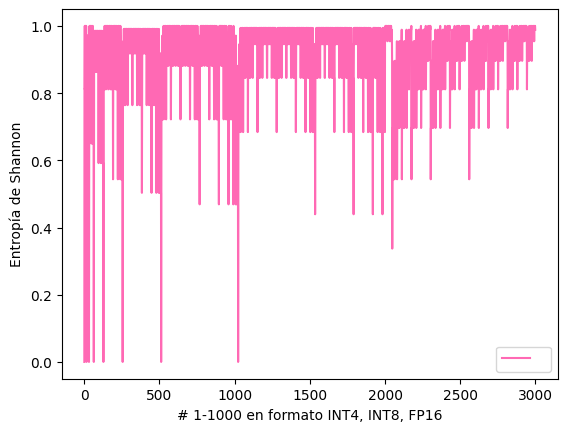

In [63]:
import matplotlib.pyplot as plt
import pandas as pd

# Cargar el archivo CSV
data = pd.read_csv('entropia.csv')

# Tomar la primera y tercera columnas
columna1 = data.iloc[:, 0]  # Cambia el índice 0 al número de la columna que desees
columna3 = data.iloc[:, 1]  # Cambia el índice 2 al número de la columna que desees

# Crear la gráfica
plt.plot(columna1, columna3, label=' ',color='hotpink')

# Etiquetas de ejes y título
plt.xlabel('# 1-1000 en formato INT4, INT8, FP16')
plt.ylabel('Entropía de Shannon')
#plt.title('Gráfica de Columna 1 vs Columna 3')

# Mostrar la leyenda
plt.legend()
plt.savefig("1000.png")
# Mostrar la gráfica
plt.show()